### Load Packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import math
import seaborn as sns

# Import Custom Module
import OeconToolbox as ott

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [OPTIONAL] Set Matplotlib Style

In [2]:
matplotlib.style.use('default')

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 10})
matplotlib.path.should_simplify = True

sns.set_style("ticks")

cm = 1/2.54
textwidth = 13.998 / 2.54

## Import Cumulative Default Table

In [3]:
DefTable = pd.read_excel("CumulativeDefaultTable.xlsx",header=[0],index_col=[0],skipfooter=5,usecols="A:K")
DefTable.round(2)

,1,2,3,4,5,6,7,8,9,10
AAA,0.00,0.03,0.10,0.19,0.27,0.37,0.41,0.46,0.52,0.58
AA,0.02,0.06,0.11,0.21,0.30,0.41,0.49,0.56,0.63,0.70
A,0.05,0.13,0.22,0.33,0.46,0.60,0.76,0.90,1.05,1.20
BBB,0.16,0.43,0.75,1.14,1.54,1.94,2.27,2.61,2.94,3.24
BB,0.63,1.93,3.46,4.99,6.43,7.75,8.89,9.90,10.82,11.64
B,3.34,7.80,11.75,14.89,17.35,19.36,20.99,22.31,23.50,24.62


# Simulating a Portfolio of loans
The SPV portfolio consists of $J$ loans from identical corporate issuers with a single class of debt outstanding. The parameters of the issuers is identical to those described in the 'Collateral Dynamics.ipynb' notebook.

## Parameters of the Corporate Issuers

In [4]:
V0 = 100      # Initial Asset Value
rf = .035     # Risk-Free Rate
rm = .105     # Market Return
beta = .8     # Firm CAPM Coefficient
sigma_i = .25 # Idiosyncratic Risk
sigma_m = .14 # Market Risk
ttm = 5       # Time to Maturity of Debt
penalty = 0   # Penalty on prepayment

Auxiliary Calculations

In [260]:
mu = rf + beta * (rm - rf)
sigma = ott.sigma_beta_adj(beta, sigma_m, sigma_i)
face_value = ott.facevalue_from_probability(DefTable.loc["B", ttm] / 100, V0, ttm, mu, sigma)
market_value = ott.mv_bond(V0, face_value, ttm, rf, sigma)
b_loan_yield = ott.zero_yield(market_value,face_value, ttm)
b_callable_yield = 0.058862441702705035
mv_call = 54.71780723807047

## Parameters of the SPV

In [6]:
J = 125    # number of loans
N = 250000 # Number of simulated portfolios

# Modelling the SPV Dynamics without Prepayment on Collateral Assets

In [7]:
max_spv_cash_flows = face_value * J
initial_market_value = market_value * J
print("The absolute maximum payoff: {0:0.2f} with initial market value: {1:0.2f}".format(max_spv_cash_flows,initial_market_value))

The absolute maximum payoff: 9180.30 with initial market value: 6990.38


Total SPV payoffs (under Q-measure)

In [275]:
SPV_Q, _ = ott.loan_portfolio(j = J,
                              n = N,
                              V = V0,
                              B = face_value,
                              T = ttm,
                              rf = rf,
                              rm = rm,
                              beta = beta,
                              sigmaI = sigma_i,
                              sigmaM = sigma_m,
                              risk_neutral=True,
                              paths=False)

Total SPV payoffs (under P-measure)

In [211]:
SPV_P, M = ott.loan_portfolio(j = J,
                              n = N,
                              V = V0,
                              B = face_value,
                              T = ttm,
                              rf = rf,
                              rm = rm,
                              beta = beta,
                              sigmaI = sigma_i,
                              sigmaM = sigma_m,
                              risk_neutral=False,
                              paths=False)

In [212]:
tmp, tranches = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(SPV_P, def_prob/100)
    if i == 0 : tranches[i] = np.quantile(SPV_P, def_prob/100)
    else: tranches[i] = np.quantile(SPV_P, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches[i] = np.quantile(SPV_P, 1) - tmp[i-1].sum(axis=0)

## Cash Flows to each Tranche

In [213]:
pd.DataFrame({'Cash Flows':tranches,'Sum':tranches.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,7233.123926,7233.123926
AA,32.553669,7265.677595
A,125.585199,7391.262794
BBB,358.089939,7749.352734
BB,442.005521,8191.358255
B,317.878967,8509.237222
Equity,671.062623,9180.299845


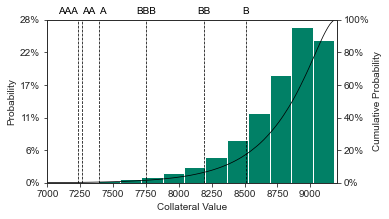

In [214]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=1)
plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()
plt.show()
#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

Data For Scatterplots

In [17]:
SPV_P_small = np.random.RandomState(1234).choice(SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(M,size=2500)

In [18]:
scatter_data = pd.DataFrame({'SPV':SPV_P_small/ max_spv_cash_flows,
                             'Market Factor':M_small / 5,
                             'AAA':ott.clo_payoffs(SPV_P_small,tranches)[0]/ tranches[0],
                             'AA':ott.clo_payoffs(SPV_P_small,tranches)[1]/ tranches[1],
                             'A':ott.clo_payoffs(SPV_P_small,tranches)[2] / tranches[2],
                             'BBB':ott.clo_payoffs(SPV_P_small,tranches)[3] / tranches[3],
                             'BB':ott.clo_payoffs(SPV_P_small,tranches)[4] / tranches[4],
                             'B':ott.clo_payoffs(SPV_P_small,tranches)[5] / tranches[5],
                             'Equity':ott.clo_payoffs(SPV_P_small,tranches)[6]/ tranches[6]})
scatter_data

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.990824,0.249813,1.0,1.0,1.0,1.0,1.0,1.0,0.874467
1,0.982318,0.007552,1.0,1.0,1.0,1.0,1.0,1.0,0.758100
2,0.976469,0.196481,1.0,1.0,1.0,1.0,1.0,1.0,0.678097
3,0.964409,-0.136603,1.0,1.0,1.0,1.0,1.0,1.0,0.513102
4,0.982938,0.328542,1.0,1.0,1.0,1.0,1.0,1.0,0.766591
...,...,...,...,...,...,...,...,...,...
2495,0.979048,0.134932,1.0,1.0,1.0,1.0,1.0,1.0,0.713368
2496,0.968940,0.348749,1.0,1.0,1.0,1.0,1.0,1.0,0.575085
2497,0.983798,0.594158,1.0,1.0,1.0,1.0,1.0,1.0,0.778358
2498,0.939418,-0.309687,1.0,1.0,1.0,1.0,1.0,1.0,0.171217


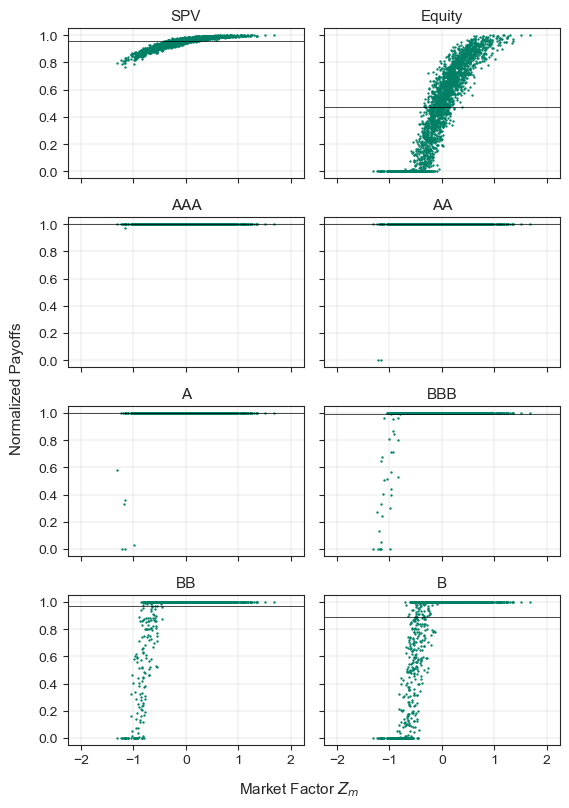

In [22]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1))
    axs[i,j].set_title(tranche, size=11)
    axs[i,j].axhline(scatter_data[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

plt.show()

#fig.savefig("Payoffs.png", bbox_inches='tight', format='png', dpi=600)

In [23]:
no_prepay_tab = DefTable[[ttm]].copy()
no_prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
no_prepay_tab['Face Value'] = (np.quantile(SPV_P, no_prepay_tab['Default Probability']/100) / initial_market_value) * 100
no_prepay_tab

,Default Probability,Face Value
AAA,0.27,103.472511
AA,0.30,103.938203
A,0.46,105.734746
BBB,1.54,110.857355
BB,6.43,117.180407
B,17.35,121.727783


In [24]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 131.33


In [25]:
for rating in no_prepay_tab.index:
    no_prepay_tab.loc[rating, 'Market Value'] = (np.minimum(SPV_Q,
                                                            np.quantile(SPV_P,
                                                                        no_prepay_tab.loc[rating, 'Default Probability']/100
                                                                       )).mean() * np.exp(-rf*ttm) / initial_market_value) * 100

Preliminary Table before "tranching"

In [26]:
no_prepay_tab

,Default Probability,Face Value,Market Value
AAA,0.27,103.472511,86.643869
AA,0.30,103.938203,87.016100
A,0.46,105.734746,88.437341
BBB,1.54,110.857355,92.307683
BB,6.43,117.180407,96.413813
B,17.35,121.727783,98.562188


Tranching:

In [27]:
no_prepay_tab.loc[:,'Face Value':'Market Value'] = no_prepay_tab.loc[:,'Face Value':'Market Value'] - no_prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
no_prepay_tab.loc['AAA','Face Value'] = (np.quantile(SPV_P, no_prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value) * 100
no_prepay_tab.loc['AAA','Market Value'] = (np.minimum(SPV_Q, np.quantile(SPV_P, no_prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value) * 100
no_prepay_tab['Yield'] = ott.zero_yield(no_prepay_tab['Market Value'], no_prepay_tab['Face Value'], ttm) * 100
no_prepay_tab.loc['Equity','Market Value'] = 100 - no_prepay_tab['Market Value'].sum(axis=0)

In [28]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


Return on equity analysis

# Introducing Prepayments on Collateral

In [290]:
SPV_Q_pp, _  = ott.loan_portfolio_PP(j = J,
                                     n = N,
                                     V = V0,
                                     B = face_value,
                                     yields = (b_loan_yield, b_callable_yield),
                                     T = ttm,
                                     rf = rf,
                                     rm = rm,
                                     beta = beta,
                                     sigmaI = sigma_i,
                                     sigmaM = sigma_m,
                                     penalty = penalty,
                                     risk_neutral=True,
                                     paths=False)

In [249]:
SPV_P_pp, M_pp  = ott.loan_portfolio_PP(j = J,
                                        n = N,
                                        V = V0,
                                        B = face_value,
                                        yields = (b_loan_yield, b_callable_yield),
                                        T = ttm,
                                        rf = rf,
                                        rm = rm,
                                        beta = beta,
                                        sigmaI = sigma_i,
                                        sigmaM = sigma_m,
                                        penalty = penalty,
                                        risk_neutral=False,
                                        paths=False)

In [291]:
tmp, tranches_pp = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(SPV_P_pp, def_prob/100)
    if i == 0 : tranches_pp[i] = np.quantile(SPV_P_pp, def_prob/100)
    else: tranches_pp[i] = np.quantile(SPV_P_pp, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches_pp[i] = np.quantile(SPV_P_pp, 1) - tmp[i-1].sum(axis=0)

# Cash Flows to each Tranche

In [292]:
pd.DataFrame({'Cash Flows':tranches_pp,'Sum':tranches_pp.cumsum()},["AAA","AA","A","BBB","BB","B","Equity"])

,Cash Flows,Sum
AAA,7490.143703,7490.143703
AA,9.324788,7499.468490
A,36.984923,7536.453413
BBB,80.994349,7617.447762
BB,112.305975,7729.753737
B,123.130830,7852.884566
Equity,1652.137488,9505.022054


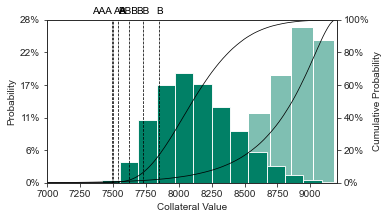

In [293]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P
simulations_pp = SPV_P_pp

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=0.5)
ax = sns.histplot(data=simulations_pp, bins=25, color=palette(1), stat='probability', alpha=1)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations_pp, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
ax2 = sns.ecdfplot(data=simulations_pp, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

plt.show()

Data for scatter plots

In [294]:
SPV_P_pp_small = np.random.RandomState(1234).choice(SPV_P_pp,size=2500)
M_small = np.random.RandomState(1234).choice(M_pp,size=2500)

In [295]:
scatter_data2 = pd.DataFrame({'SPV':SPV_P_pp_small/ max_spv_cash_flows,
                             'Market Factor':M_small / 5,
                             'AAA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[0]/ tranches_pp[0],
                             'AA':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[1]/ tranches_pp[1],
                             'A':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[2] / tranches_pp[2],
                             'BBB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[3] / tranches_pp[3],
                             'BB':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[4] / tranches_pp[4],
                             'B':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[5] / tranches_pp[5],
                             'Equity':ott.clo_payoffs(SPV_P_pp_small,tranches_pp)[6]/ tranches_pp[6]})
scatter_data2

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.928770,-0.313497,1.0,1.0,1.0,1.0,1.0,1.0,0.407657
1,0.907305,-0.231447,1.0,1.0,1.0,1.0,1.0,1.0,0.288384
2,0.897038,0.512353,1.0,1.0,1.0,1.0,1.0,1.0,0.231331
3,0.881867,-0.662181,1.0,1.0,1.0,1.0,1.0,1.0,0.147031
4,0.908527,-0.077695,1.0,1.0,1.0,1.0,1.0,1.0,0.295171
...,...,...,...,...,...,...,...,...,...
2495,0.901229,0.178137,1.0,1.0,1.0,1.0,1.0,1.0,0.254623
2496,0.886853,0.478181,1.0,1.0,1.0,1.0,1.0,1.0,0.174738
2497,0.910310,-0.343024,1.0,1.0,1.0,1.0,1.0,1.0,0.305080
2498,0.862211,0.580636,1.0,1.0,1.0,1.0,1.0,1.0,0.037813


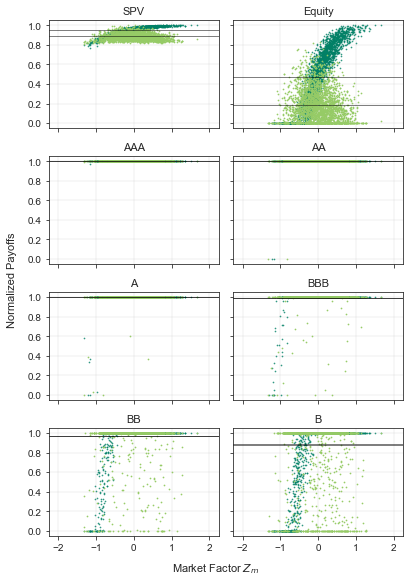

In [296]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1),alpha=0.75)
    axs[i,j].scatter(x=scatter_data2['Market Factor'], y = scatter_data2[tranche], s= 0.5, color=palette(150))
    axs[i,j].set_title(tranche, size=11)
    
    axs[i,j].axhline(scatter_data[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    axs[i,j].axhline(scatter_data2[tranche].mean(),-2.25, 2.25,c="k",linewidth=0.5)
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

#fig.savefig("Payoffs.pdf", bbox_inches='tight', format='pdf')

plt.show()

In [297]:
initial_market_value_prepayment = mv_call * J

In [298]:
prepay_tab = DefTable[[ttm]].copy()
prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
prepay_tab['Face Value'] = (np.quantile(SPV_P_pp, prepay_tab['Default Probability']/100) / initial_market_value_prepayment) * 100
prepay_tab

,Default Probability,Face Value
AAA,0.27,109.509413
AA,0.30,109.645746
A,0.46,110.186483
BBB,1.54,111.370658
BB,6.43,113.012624
B,17.35,114.812855


In [299]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value_prepayment * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 134.22


In [300]:
for rating in prepay_tab.index:
    prepay_tab.loc[rating, 'Market Value'] = (np.minimum(SPV_Q_pp,
                                                         np.quantile(SPV_P_pp,
                                                                     prepay_tab.loc[rating, 'Default Probability']/100
                                                                    )).mean() * np.exp(-rf*ttm) / initial_market_value_prepayment) * 100

In [301]:
SPV_P_pp.mean() / SPV_Q_pp.mean()

1.007644133527843

In [302]:
SPV_P.mean() / SPV_Q.mean()

1.0536166869625005

Preliminary table before tranching

In [303]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,109.51,91.82
AA,0.30,109.65,91.93
A,0.46,110.19,92.37
BBB,1.54,111.37,93.30
BB,6.43,113.01,94.54
B,17.35,114.81,95.76


Tranching

In [304]:
prepay_tab.loc[:,'Face Value':'Market Value'] = prepay_tab.loc[:,'Face Value':'Market Value'] - prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
prepay_tab.loc['AAA','Face Value'] = (np.quantile(SPV_P_pp, prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value_prepayment) * 100
prepay_tab.loc['AAA','Market Value'] = (np.minimum(SPV_Q_pp, np.quantile(SPV_P_pp, no_prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value_prepayment) * 100
prepay_tab['Yield'] = ott.zero_yield(prepay_tab['Market Value'], prepay_tab['Face Value'], ttm) * 100
prepay_tab.loc['Equity','Market Value'] = 100 - prepay_tab['Market Value'].sum(axis=0)

In [305]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,109.51,91.82,3.52
AA,0.30,0.14,0.11,4.31
A,0.46,0.54,0.43,4.41
BBB,1.54,1.18,0.93,4.74
BB,6.43,1.64,1.24,5.68
B,17.35,1.80,1.22,7.74
Equity,NaN,NaN,4.24,NaN


Comparison with no prepayment case

In [306]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


<AxesSubplot:ylabel='Probability'>

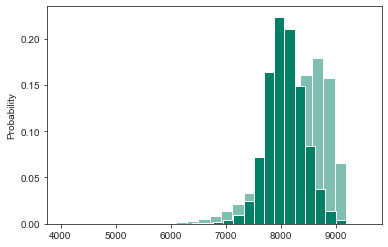

In [307]:
sns.histplot(data=SPV_Q, bins=25, color=palette(1), stat='probability', alpha=0.5)
sns.histplot(data=SPV_Q_pp, bins=25, color=palette(1), stat='probability', alpha=1)